<a href="https://colab.research.google.com/github/petergchang/sarkka-jax/blob/main/Ch8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#8. Bayesian Smoothing Equations and Exact Solutions

This notebook replicates the figures of Chapter 8 of Särkkä's "Bayesian Filtering and Smoothing" using JAX.

Simo Särkkä (2013), “Bayesian Filtering and Smoothing,” Cambridge University Press. Available: https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf

This JAX translation is by Peter G. Chang ([@petergchang](https://github.com/petergchang))

##8.0 Imports and Gaussian Random Walk / Car Tracking Simulations

In [1]:
%matplotlib inline

import jax
import jax.numpy as jnp
import jax.random as jr
from jax import lax
import matplotlib.pyplot as plt

First, we simulate Gaussian random walk as we did in Chapter 4.

In [2]:
# 1-dimensional random walk simulation
def simulate_rw_1d(key, init, Q, R, num_steps):
    def _step(carry, rng):
        x_prev = carry

        # Random walk and measurement
        key1, key2 = jr.split(rng)
        x_post = x_prev + jr.normal(key1)*Q
        y = x_post + jr.normal(key2)
        return x_post, (x_post, y)

    carry = init
    rngs = jr.split(key, num_steps)
    _, (xs, ys) = lax.scan(
        _step, carry, rngs
    )
    return xs, ys

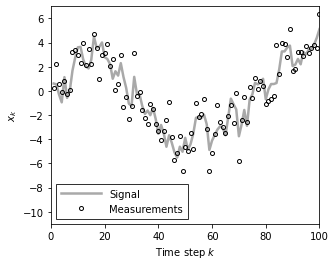

In [3]:
# Generate random walk data with num_steps=100
key = jr.PRNGKey(0)
grw_xs, grw_ys = simulate_rw_1d(key, 0, 1, 1, 100)

# Generate grid
t_grid = jnp.arange(1,101)

# Plot the generated data
plt.figure()
plt.plot(t_grid, grw_xs, color='darkgray', linewidth=2.5, label="Signal")
plt.plot(t_grid, grw_ys, 'ok', fillstyle='none', ms=4, label='Measurements')
plt.xlabel('Time step $k$'); plt.ylabel('$x_k$')
plt.xlim(0, 100); plt.ylim(-11, 7)
plt.yticks(jnp.arange(-10, 7, 2))
plt.gca().set_aspect(4.5)
plt.legend(loc=3, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

Next, we simulate car tracking as we did in Chapter 4.

In [4]:
# Function to simulate car trajectory
def simulate_trajectory(key, m_0, A, Q, H, R, steps):
    def _step(carry, rng):
        state = carry
        rng1, rng2 = jr.split(rng, 2)
        next_state = A @ state + jr.multivariate_normal(rng1, jnp.zeros(M), Q)
        observation = H @ state + jr.multivariate_normal(rng2, jnp.zeros(N), R)
        return next_state, (state, observation)

    M, N = m_0.shape[-1], R.shape[-1]
    state = m_0
    rngs = jr.split(key, steps)
    _, (states, observations) = lax.scan(
        _step, state, rngs
    )
    return states, observations

In [5]:
# Params for car trajectory simulation
key = jr.PRNGKey(42)
m_0 = jnp.array([0., 0., 1., -1.])
dt = 0.1
q1, q2 = 1, 1
rsig1, rsig2 = 0.5, 0.5
A = jnp.array([[1, 0, dt,  0],
               [0, 1,  0, dt],
               [0, 0,  1,  0],
               [0, 0,  0,  1]])
Q = jnp.array([[q1*dt**3/3,          0, q1*dt**2/2,          0],
               [         0, q2*dt**3/3,          0, q2*dt**2/2],
               [q1*dt**2/2,          0,      q1*dt,          0],
               [         0, q2*dt**2/2,          0,      q2*dt]])
H = jnp.array([[1, 0, 0, 0],
               [0, 1, 0, 0]])
R = jnp.array([[rsig1**2,        0],
               [       0, rsig2**2]])

# Simulate car trajectory
ct_xs, ct_ys = simulate_trajectory(key, m_0, A, Q, H, R, 100)

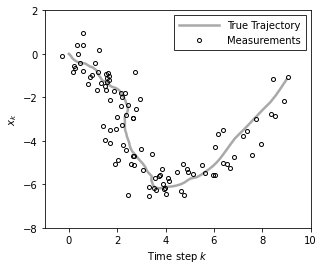

In [6]:
# Plot the generated data
plt.figure()
plt.plot(ct_xs[:,0], ct_xs[:,1], color='darkgray', linewidth=2.5, label="True Trajectory")
plt.plot(ct_ys[:,0], ct_ys[:,1], 'ok', fillstyle='none', ms=4, label='Measurements')
plt.xlabel('Time step $k$'); plt.ylabel('$x_k$')
plt.xlim(-1, 10); plt.ylim(-8, 2)
plt.yticks(jnp.arange(-8, 2.1, 2))
plt.gca().set_aspect(0.9)
plt.legend(loc=1, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()

##8.2 Rauch-Tung-Striebel Smoother

In [10]:
# Kalman filter (Theorem 4.2)
def kalman_filter(m_0, P_0, H, R, A, Q, Y):
    def _step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = A @ m_k
        P_pred = A @ P_k @ A.T + Q

        # Update step
        v = Y[t] - H @ m_pred
        S = jnp.atleast_2d(H @ P_pred @ H.T + R)
        K = P_pred @ H.T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ v
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)

    num_timesteps = len(Y)
    carry = (m_0, P_0)
    _, (ms, Ps) = lax.scan(
        _step, carry, jnp.arange(num_timesteps)
    )
    return ms, Ps

In [38]:
# RTS Smoother (Theorem 8.2)
def rts_smoother(m_0, P_0, H, R, A, Q, Y):
    # Forward step is equivalent to Kalman filter
    def _forward_step(carry, t):
        m_k, P_k = carry

        # Prediction step
        m_pred = A @ m_k
        P_pred = A @ P_k @ A.T + Q

        # Update step
        v = Y[t] - H @ m_pred
        S = jnp.atleast_2d(H @ P_pred @ H.T + R)
        K = P_pred @ H.T @ jnp.linalg.inv(S)
        m_post = m_pred + K @ v
        P_post = P_pred - K @ S @ K.T

        return (m_post, P_post), (m_post, P_post)

    def _backward_step(carry, t):
        m_sm, P_sm = carry

        # Prediction step
        m_pred = A @ m_post[t]
        P_pred = A @ P_post[t] @ A.T + Q

        # Update step
        G = P_post[t] @ A.T @ jnp.linalg.inv(P_pred)
        m_sm_post = m_post[t] + G @ (m_sm - m_pred)
        P_sm_post = P_post[t] + G @ (P_sm - P_pred) @ G.T

        return (m_sm_post, P_sm_post), (m_sm_post, P_sm_post)

    num_timesteps = len(Y)
    # First, run forward step to compute posterior
    carry = (m_0, P_0)
    _, (m_post, P_post) = lax.scan(
        _forward_step, carry, jnp.arange(num_timesteps)
    )
    # Next, run backward step to compute smoothed posterior
    carry = (m_post[-1], P_post[-1])
    _, (m_sm, P_sm) = lax.scan(
        _backward_step, carry, jnp.arange(num_timesteps-2, -1, -1)
    )
    m_sm = jnp.concatenate((jnp.array([m_post[-1]]), m_sm))[::-1]
    P_sm = jnp.concatenate((jnp.array([P_post[-1]]), P_sm))[::-1]

    return m_sm, P_sm

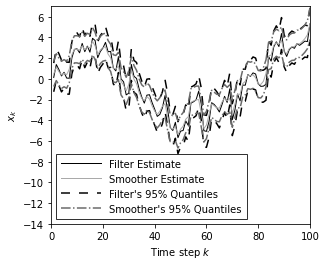

In [39]:
# RTS smoother params
m_0 = jnp.zeros((1,1))
P_0 = jnp.zeros((1,1))
H = jnp.ones((1,1))
R = jnp.ones((1,1))
A = jnp.ones((1,1))
Q = jnp.ones((1,1))

# Run Kalman filter on the 1d random walk data
m_kf, P_kf = kalman_filter(m_0, P_0, H, R, A, Q, grw_ys)
m_kf, P_kf = jnp.ravel(m_kf), jnp.ravel(P_kf)

# Run RTS smoother on the 1d random walk data
m_rts, P_rts = rts_smoother(m_0, P_0, H, R, A, Q, grw_ys)
m_rts, P_rts = jnp.ravel(m_rts), jnp.ravel(P_rts)

# 95% confidence intervals
ci_kf = 1.96 * jnp.sqrt(P_kf)
ci_rts = 1.96 * jnp.sqrt(P_rts)

# Plot the generated data (Replicates Figure 8.1)
plt.figure()
plt.plot(t_grid, m_kf, color='k', linewidth=1, label="Filter Estimate")
plt.plot(t_grid, m_rts, color='darkgray', linewidth=1, label="Smoother Estimate")
plt.plot(t_grid, m_kf-ci_kf, 'k', dashes=[6,6], linewidth=1.5, label="Filter's 95% Quantiles")
plt.plot(t_grid, m_kf+ci_kf, 'k', linewidth=1.5, dashes=[6,6])
plt.plot(t_grid, m_rts-ci_rts, 'dimgray', linestyle='dashdot', linewidth=1.5, label="Smoother's 95% Quantiles")
plt.plot(t_grid, m_rts+ci_rts, 'dimgray', linestyle='dashdot', linewidth=1.5)
plt.xlabel('Time step $k$'); plt.ylabel('$x_k$')
plt.xlim(0, 100); plt.ylim(-14, 7)
plt.yticks(jnp.arange(-14, 7, 2))
plt.gca().set_aspect(4)
plt.legend(loc=3, borderpad=0.5, handlelength=4, fancybox=False, edgecolor='k');
plt.show()